
## Семинар 4. Модели экспоненциального сглаживания. Порядок построения и валидации модели.



## Работа над ошибками. 
### Нормировка временных рядов.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import holidays
import numpy as np
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf



plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)



# Загрузим данные по энергетике
data = pd.read_csv('data/sem_2/energy_dataset.csv')

# # Преобразуем даты
data.index = pd.to_datetime(data.time.apply(lambda x: x.split('+')[0]))
data = data.drop(columns=['time'])

# Загрузим данные по погоде
weather = pd.read_csv('data/sem_2/weather_features.csv')

# Преобразуем даты
weather.loc[:, 'dt_iso']= pd.to_datetime(weather.dt_iso.apply(lambda x: x.split('+')[0]))
weather = weather.loc[:, ['dt_iso', 'temp']]
# weather = weather.drop(columns=['dt_iso'])

# Усредним по регионам
weather = weather.groupby('dt_iso').mean()
weather.index.name = 'time'

weather

data = data.merge(weather.loc[:, ['temp']], how='left', left_on='time', right_on='time')
data = data.loc[:, ['total load actual', 'temp']]
data = data.rename(columns={'total load actual': 'y',})
data = data.resample('D').mean()

raw_columns = ['y', 'temp']

In [73]:
data

,y,temp
time,,
2015-01-01,23896.750000,276.928845
2015-01-02,27251.291667,277.897585
2015-01-03,25110.666667,278.817864
2015-01-04,27112.625000,279.630031
2015-01-05,22559.444444,279.032920
...,...,...
2018-12-27,28532.208333,280.774514
2018-12-28,28637.750000,280.972111
2018-12-29,26636.750000,281.231583


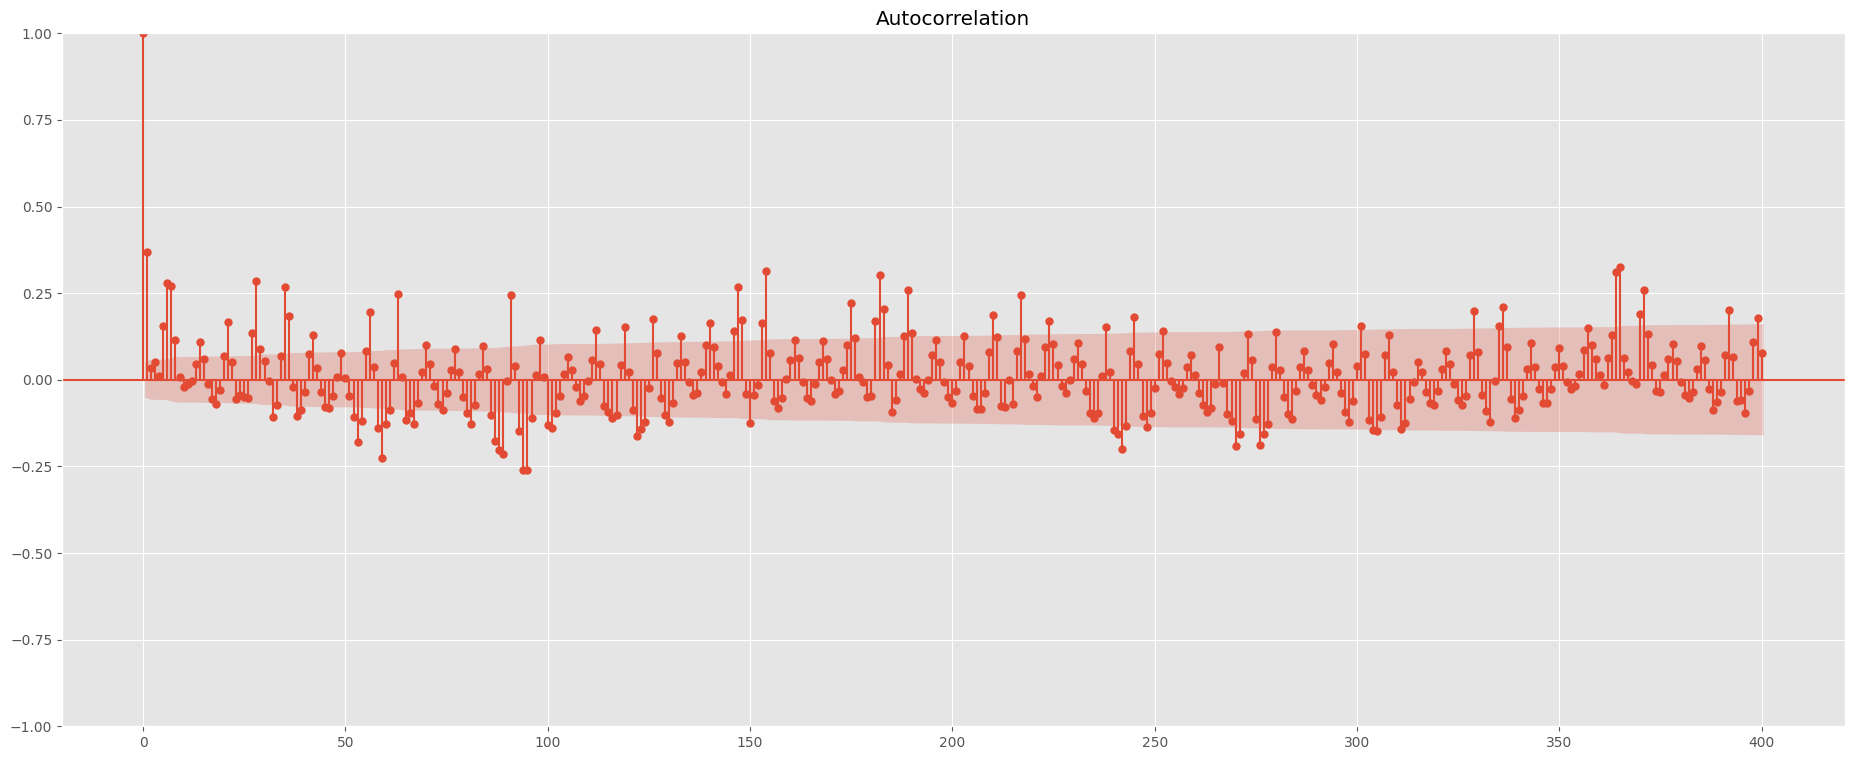

In [75]:
plot_acf(data['y'], lags=400);

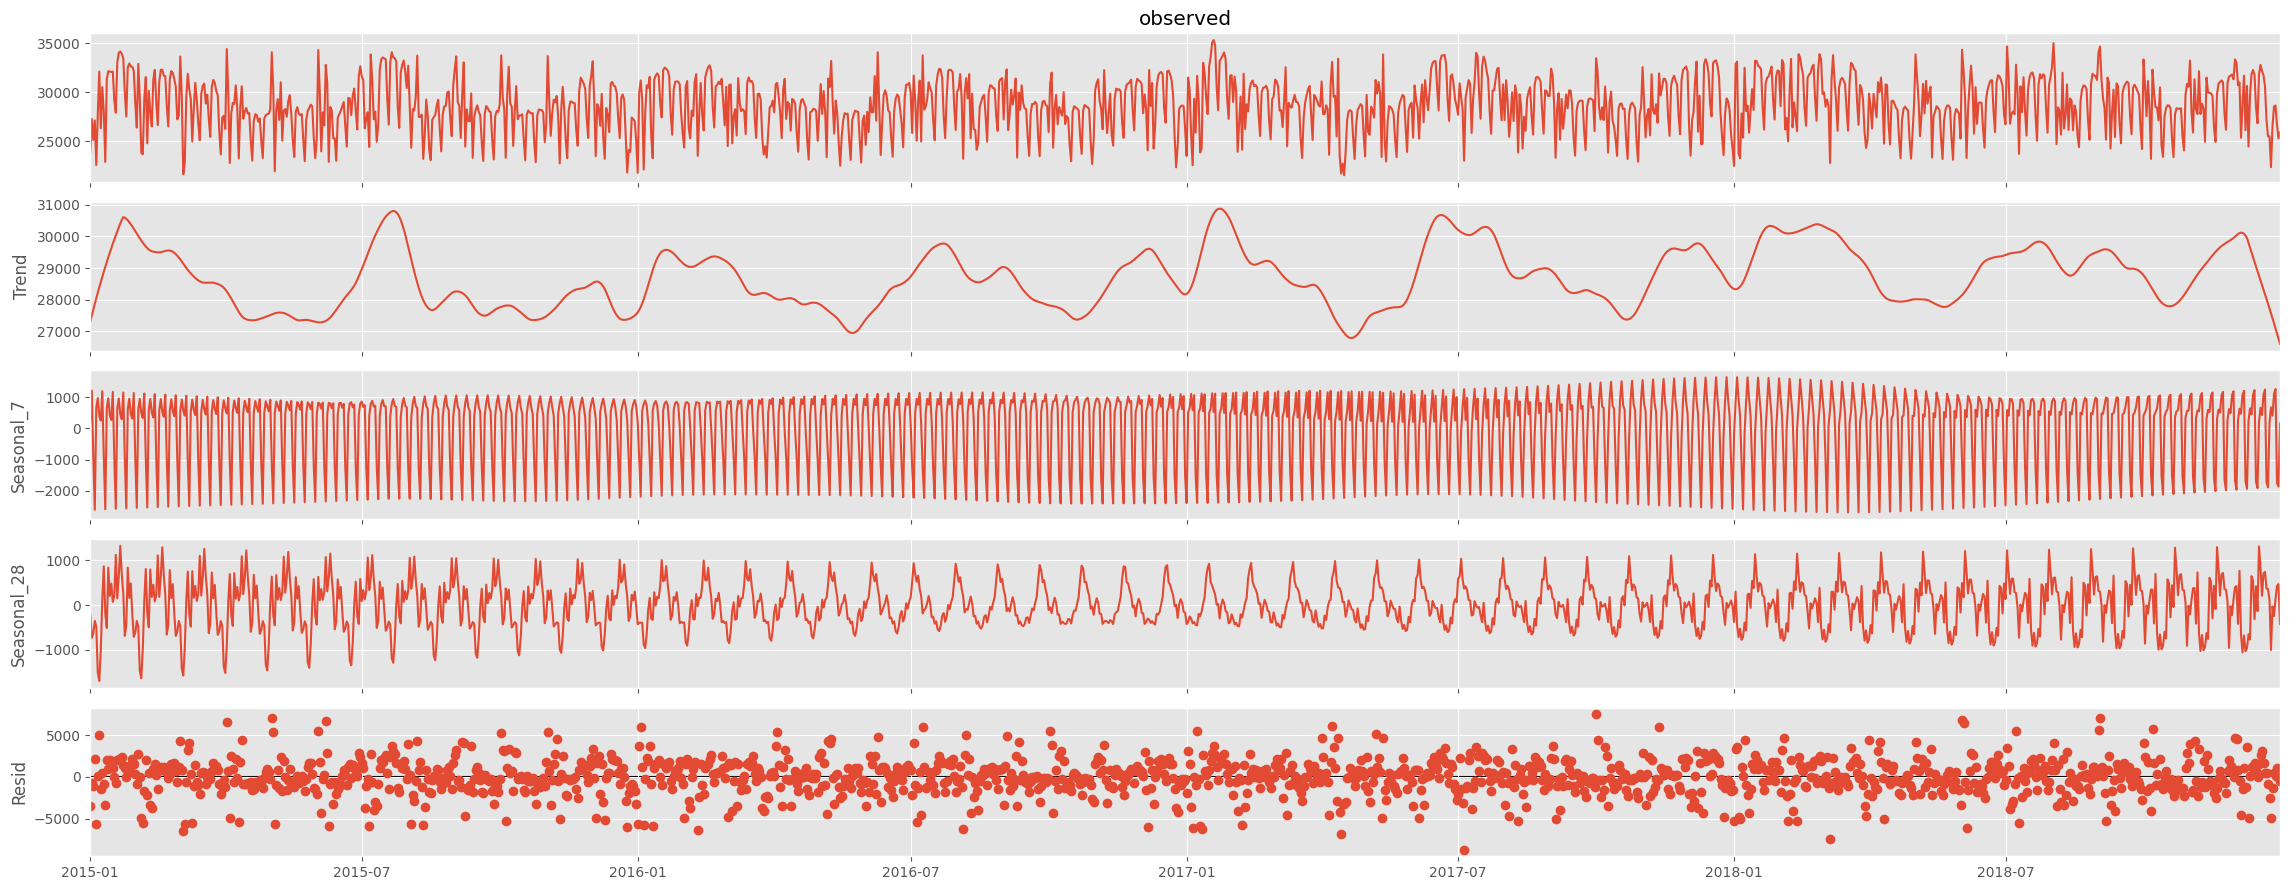

In [76]:
stl = MSTL(data['y'], periods=[7,28], windows=[61, 61])
res = stl.fit()
res.plot();

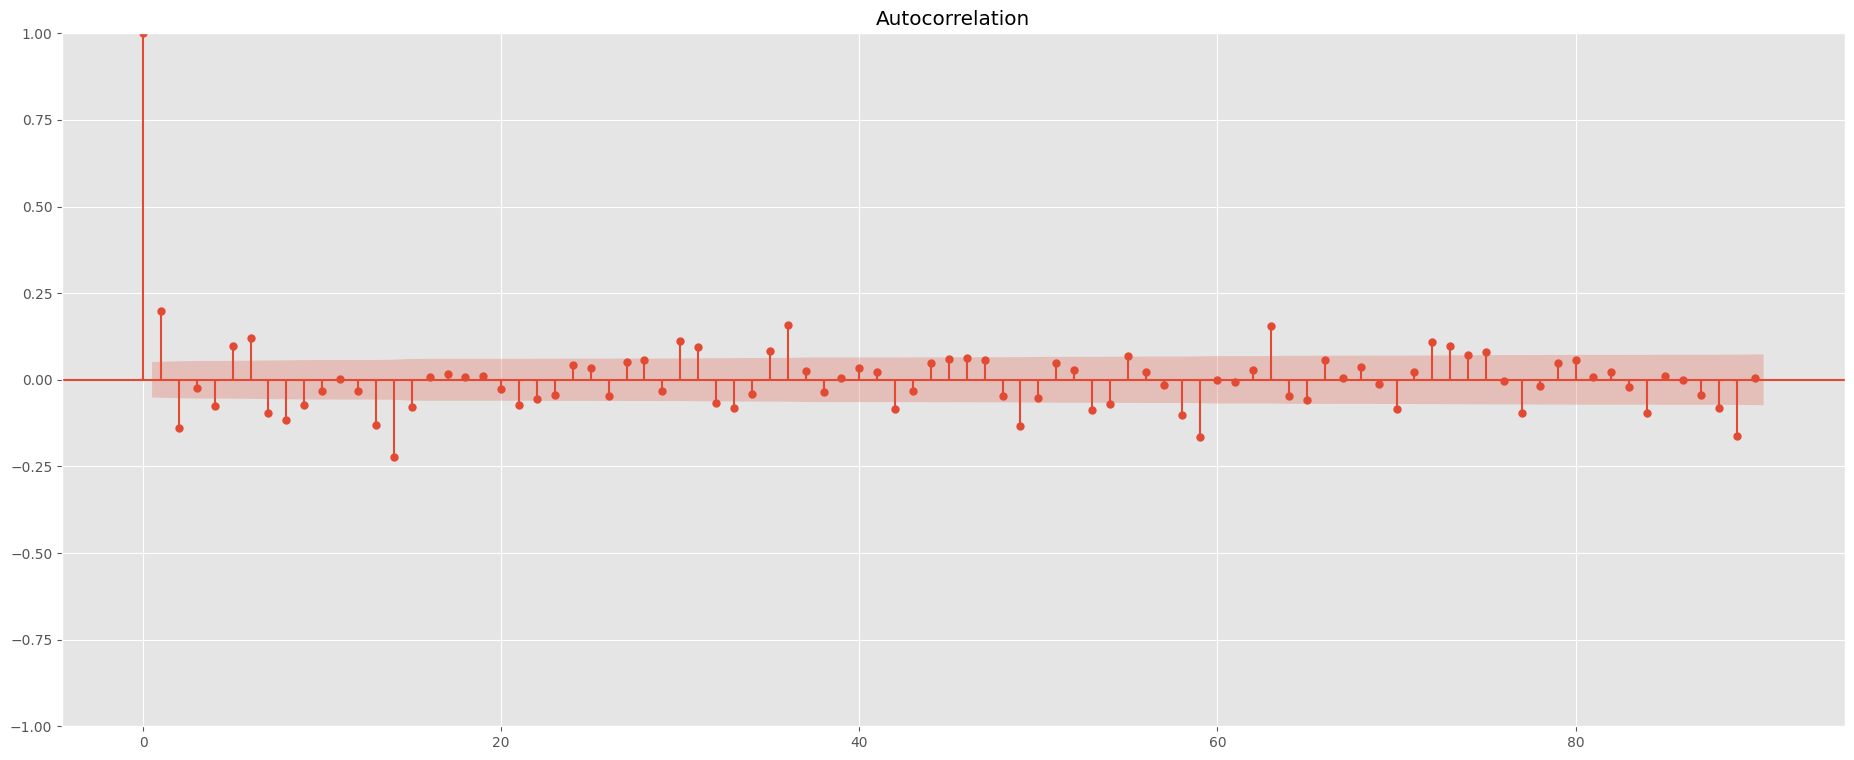

In [77]:
plot_acf(res.resid, lags=90);

<Axes: xlabel='time'>

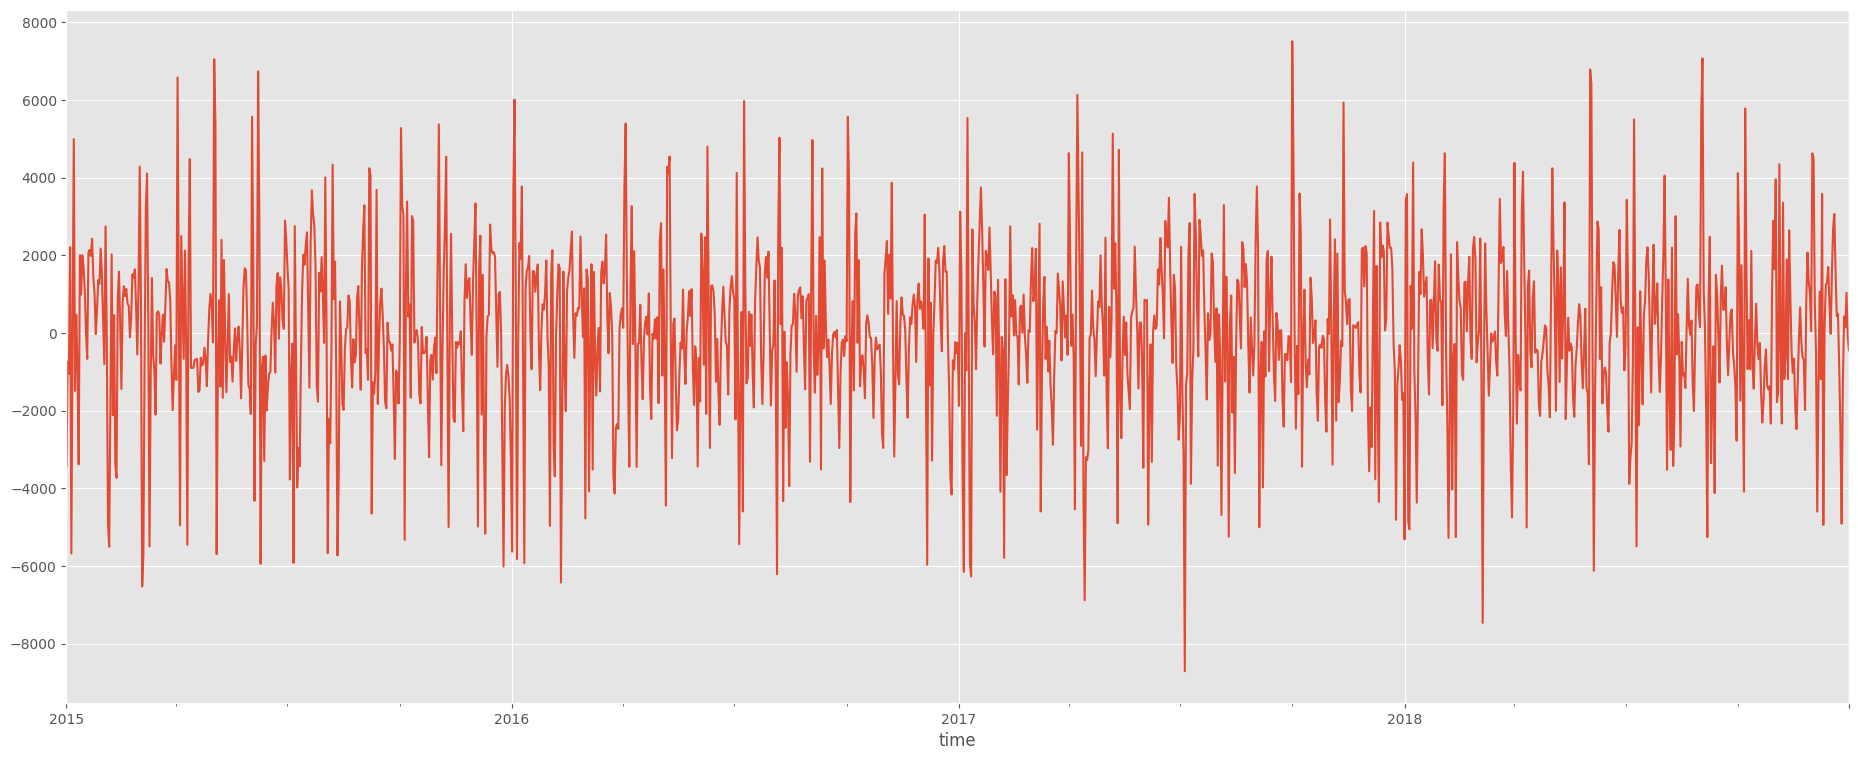

In [78]:
res.resid.plot()

In [79]:
data['y'] = res.resid

es_holidays = holidays.Spain()

train_size = int(len(data) * 0.8)

scaler = MinMaxScaler()

# вычисляем нормировку на тренировочной выборке
scaler.fit(data.head(train_size))

data_scaled = pd.DataFrame(
    scaler.transform(data),
    index=data.index,
    columns=data.columns)

WINDOW = 7


data_scaled['y_L1'] = data_scaled['y'].shift(1)
data_scaled['y_L2'] = data_scaled['y'].shift(2)
data_scaled['y_L3'] = data_scaled['y'].shift(3)
data_scaled['y_L4'] = data_scaled['y'].shift(4)

data_scaled['y_L6'] = data_scaled['y'].shift(6)
data_scaled['y_L7'] = data_scaled['y'].shift(7)
data_scaled['y_L14'] = data_scaled['y'].shift(14)
data_scaled['y_L31'] = data_scaled['y'].shift(31)

data_scaled['rolling_mean'] = data_scaled['y'].rolling(WINDOW).mean().shift(1)


t = (data_scaled.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
t = np.arange(data_scaled.shape[0])+1

data_scaled['sin_7'] = np.sin(t * np.pi * 2 / 7)
data_scaled['cos_7'] = np.cos(t * np.pi * 2 / 7)

data_scaled['sin_365'] = np.sin(t * np.pi * 2 / 365)
data_scaled['cos_365'] = np.cos(t * np.pi * 2 / 365)

data_scaled['is_holiday'] = data_scaled.index.to_series().apply(lambda x: x in es_holidays)

data_scaled = data_scaled.dropna()

train_scaled, test_scaled = train_test_split(data_scaled, train_size=train_size, shuffle=False)

test = pd.DataFrame(
    scaler.inverse_transform(test_scaled.loc[:, raw_columns]),
    index=test_scaled.index,
    columns=raw_columns
)


In [80]:
y_train, X_train = train_scaled.loc[:, ['y']], train_scaled.drop(columns=['y'])
y_test, X_test = test_scaled.loc[:, ['y']], test_scaled.drop(columns=['y'])

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.1773318414993753

In [81]:
raw_predictions = test_scaled.loc[:, raw_columns].copy()
raw_predictions['y'] = reg.predict(X_test)

predictions = pd.DataFrame(
    scaler.inverse_transform(
        raw_predictions
    ), 
    index=test_scaled.index, 
    columns=raw_columns
)

mean_absolute_percentage_error(test['y'], predictions['y'])

3.20750169820211

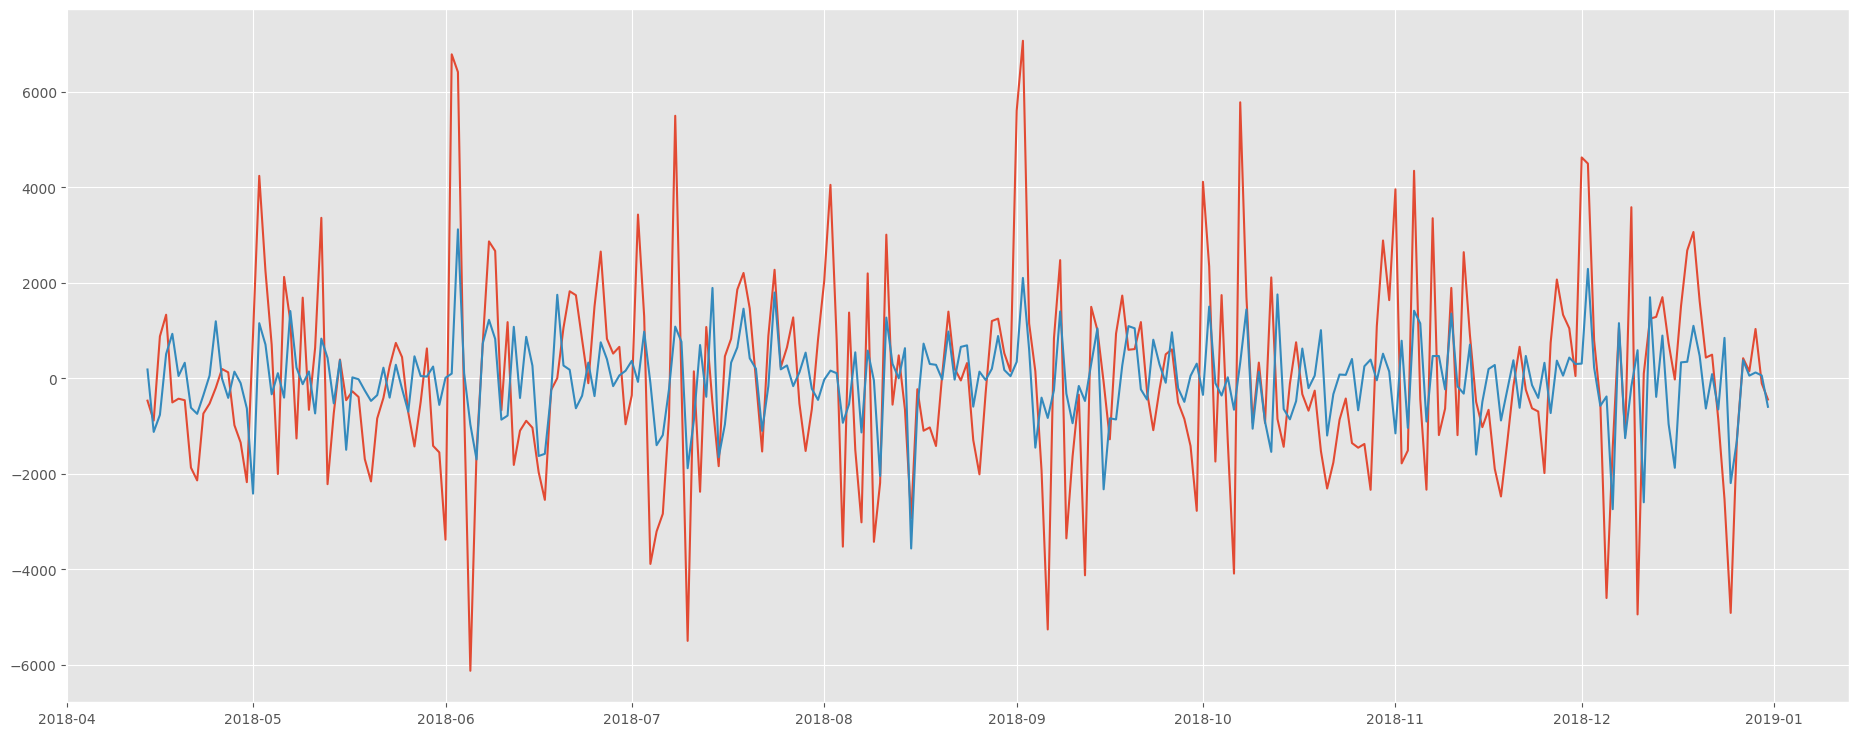

In [82]:
plt.plot(test['y'])
plt.plot(predictions['y'])

In [83]:
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.datasets import macrodata

from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


In [84]:
data = pd.read_csv("data/sem_3/Uschange.csv", index_col=0)
data.head()



,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.615986,0.972261,-2.452700,4.810312,0.9
1,1970 Q2,0.460376,1.169085,-0.551525,7.287992,0.5
2,1970 Q3,0.876791,1.553271,-0.358708,7.289013,0.5
3,1970 Q4,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1971 Q1,1.897371,1.987154,1.909734,3.657771,-0.1


### Модели Хольта-Винтерса и ETS

Для начала возьмём какие-нибудь простые данные без трендов. В нашем случае это будет один из стандартных датасетов. Используем процентные изменения в совокупном потреблении США c 1960 по 2006.

In [85]:
data.loc[:, "ds"] = pd.date_range(start="1970.01.01", periods=len(data), freq="Q")
data["unique_id"] = "1"
data = data.rename(columns={"Consumption": "y"})
y = data.loc[:, ['ds', 'unique_id', 'y']]

y

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_3596/8651525.py:1: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



,ds,unique_id,y
0,1970-03-31,1,0.615986
1,1970-06-30,1,0.460376
2,1970-09-30,1,0.876791
3,1970-12-31,1,-0.274245
4,1971-03-31,1,1.897371
...,...,...,...
182,2015-09-30,1,0.664970
183,2015-12-31,1,0.561680
184,2016-03-31,1,0.404682
185,2016-06-30,1,1.047707


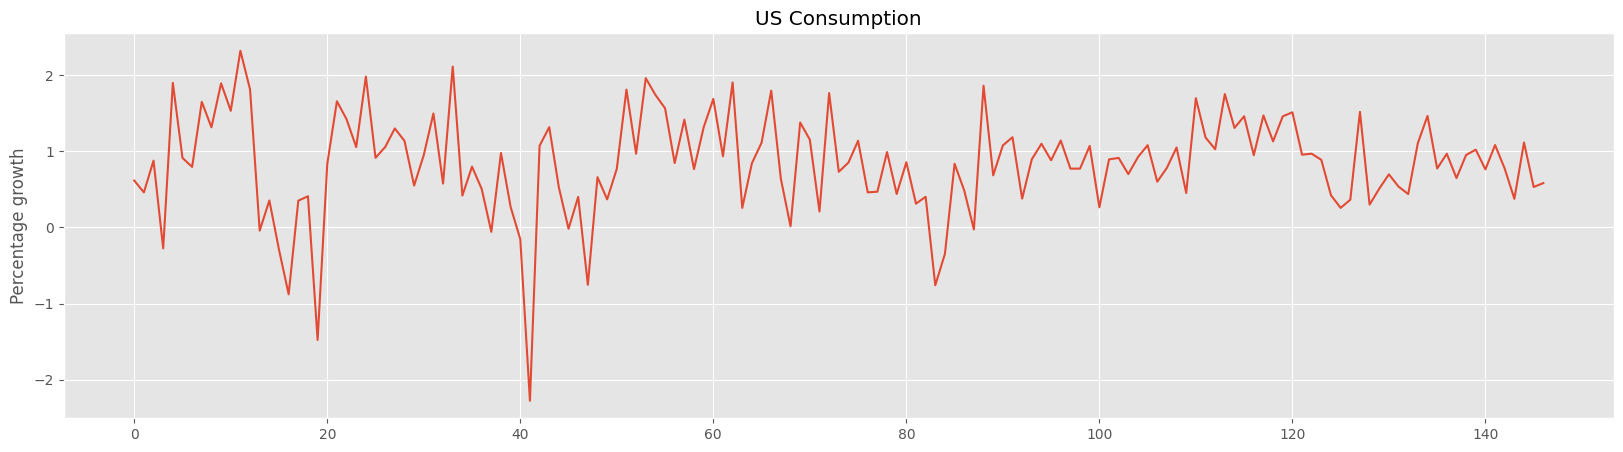

In [86]:
horizon = 10 * 4

# Если потребуются мультипликативные модели, необходимо децентрировать данные
# y = y + 10

y_train, y_test = train_test_split(y, shuffle=False, test_size=horizon)

y_train['y'].plot()
plt.title("US Consumption")
plt.ylabel("Percentage growth");

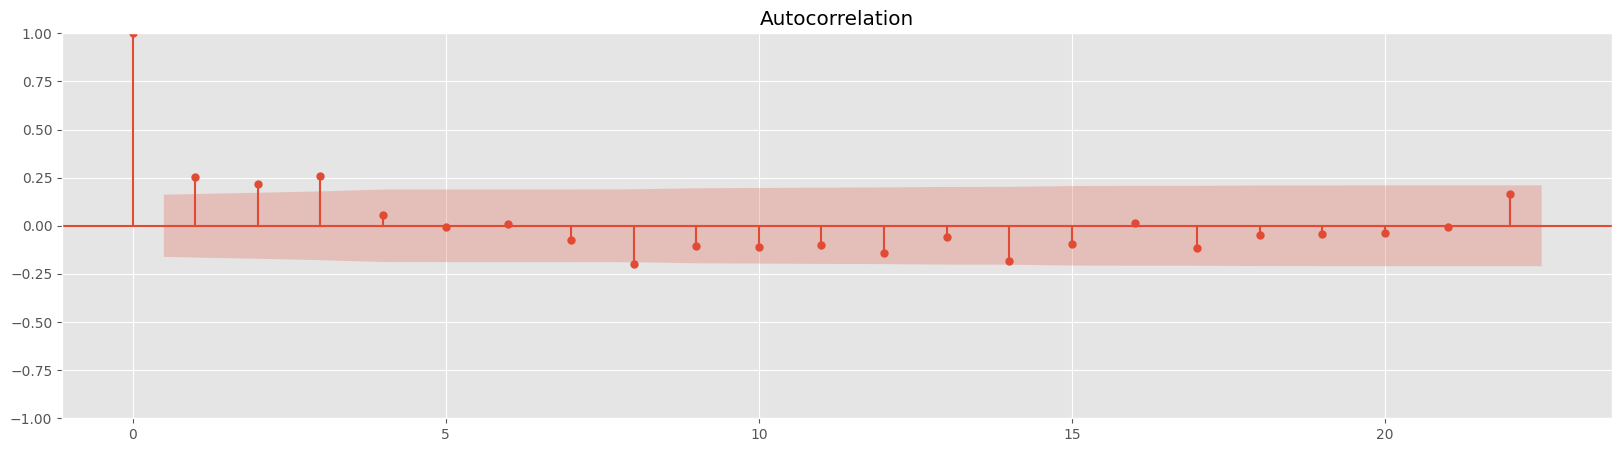

In [88]:
plot_acf(y_train['y']);

Импортируем модели Хольта-Винтерса и ETS. Из последнего семинара мы знаем, что эти модели в целом различаются только метедом оценки, но структурно эквивалентны. Посмотрим на простом примере, а далее будем использовать только ETS, чтобы не дублировать слишком много кода.

In [96]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



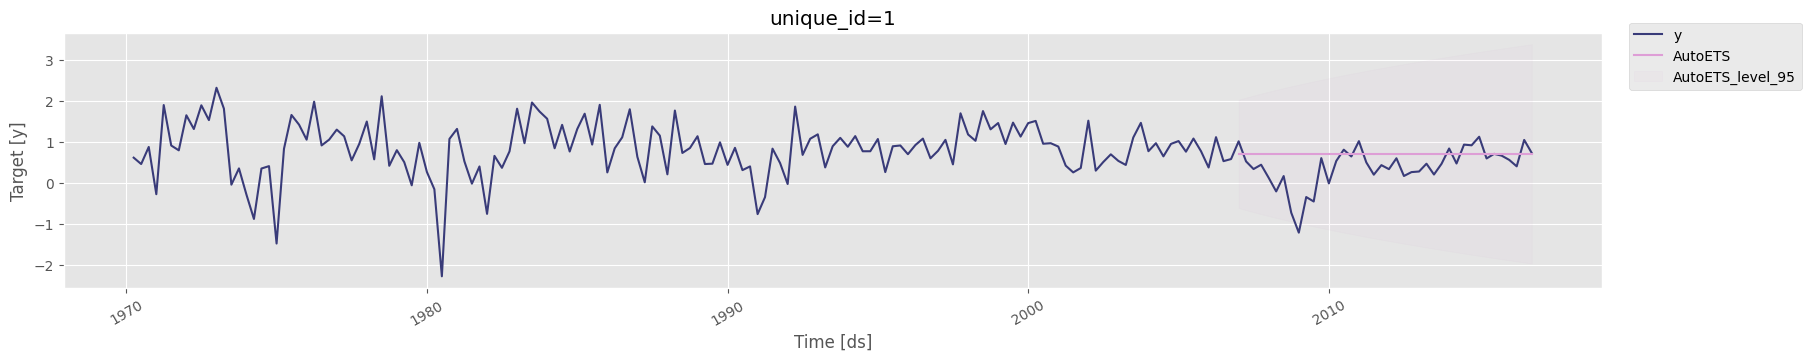

In [97]:
sf = StatsForecast(models=[AutoETS(model="ANN")], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(data, y_hat, level=[95])

In [98]:
sf.fitted_[0,0].model_

{'loglik': -306.3657740760458,
 'aic': 618.7315481520916,
 'bic': np.float64(627.7028459124278),
 'aicc': 618.8993803199238,
 'mse': np.float64(0.4394678294443533),
 'amse': np.float64(0.4810807787017892),
 'fit': results(x=array([0.28227456, 0.72686717]), fn=612.7315481520916, nit=17, simplex=None),
 'residuals': array([-1.10880949e-01, -2.35192606e-01,  2.47612017e-01, -9.73319120e-01,
         1.47304001e+00,  7.18604365e-02, -6.58780006e-02,  8.06766305e-01,
         2.44171412e-01,  7.53000810e-01,  1.79686884e-01,  9.16546563e-01,
         1.50273230e-01, -1.74462420e+00, -8.56185646e-01, -1.26037394e+00,
        -1.48999822e+00,  1.58753856e-01,  1.72403835e-01, -1.76166772e+00,
         1.04367251e+00,  1.57264731e+00,  8.92314664e-01,  2.75395960e-01,
         1.12325960e+00, -2.59872176e-01, -4.51096830e-02,  2.11198630e-01,
        -1.09397585e-02, -5.94286877e-01, -2.66229171e-02,  5.27036671e-01,
        -5.42233623e-01,  1.14653874e+00, -8.70346787e-01, -2.44705718e-01,
 

In [91]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,0.406052
1,1,mape,2.679850
2,1,mase,0.592440
3,1,rmse,0.565821
4,1,smape,0.352484


/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



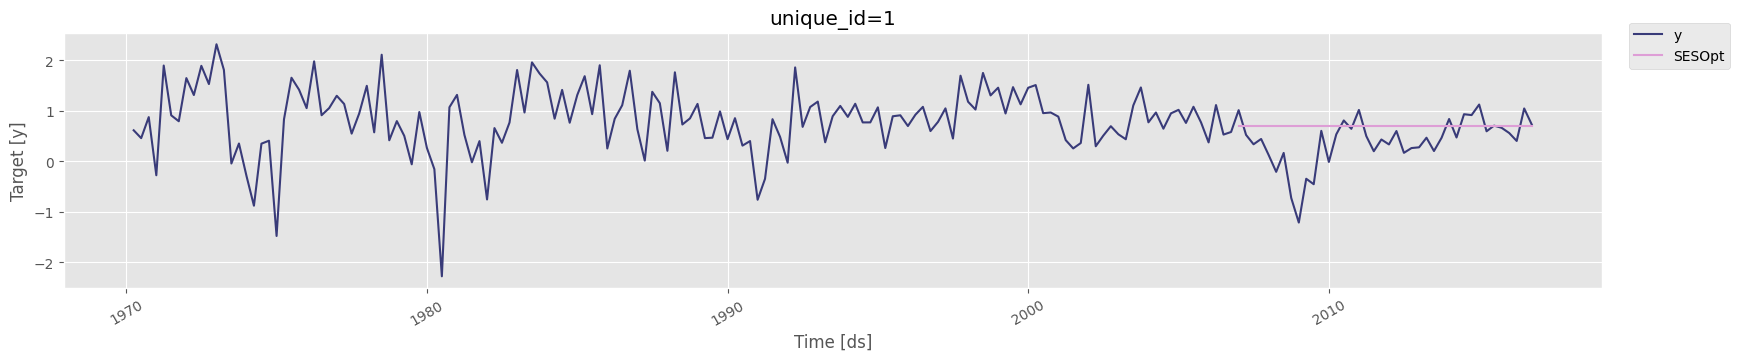

In [95]:
from statsforecast.models import SimpleExponentialSmoothingOptimized

sf = StatsForecast(models=[SimpleExponentialSmoothingOptimized()], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon)
sf.plot(data, y_hat)

# Не сработает, так как модель не стохастическая
# y_hat = sf.predict(h=horizon, level=[95])
# sf.plot(data, y_hat, level=[95])

In [93]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,SESOpt
0,1,mae,0.405459
1,1,mape,2.675028
2,1,mase,0.591575
3,1,rmse,0.565187
4,1,smape,0.352248


In [19]:
sf.fitted_[0,0].model_

{'mean': array([0.70688323]),
 'fitted': array([        nan,  0.61598622,  0.5715929 ,  0.6586614 ,  0.39251736,
         0.82182913,  0.84755148,  0.83242778,  1.06526572,  1.13614657,
         1.35163026,  1.40272012,  1.66391962,  1.705805  ,  1.20725702,
         0.96390298,  0.60571792,  0.18271309,  0.23076146,  0.28178072,
        -0.21963277,  0.08045554,  0.52988721,  0.78365746,  0.86089029,
         1.18014962,  1.10419724,  1.09025423,  1.1497772 ,  1.145954  ,
         0.97592049,  0.96848372,  1.1189753 ,  0.96392892,  1.29123064,
         1.04210061,  0.97244163,  0.83932899,  0.58340504,  0.69577731,
         0.57381593,  0.3662043 , -0.38703724,  0.02917   ,  0.39641122,
         0.43301796,  0.30455423,  0.3322546 ,  0.0226833 ,  0.20432425,
         0.251173  ,  0.39905654,  0.8012235 ,  0.84881072,  1.16566442,
         1.32936939,  1.3962755 ,  1.23908042,  1.28928042,  1.13984416,
         1.18947129,  1.3312812 ,  1.21804844,  1.4133311 ,  1.08332352,
         1.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



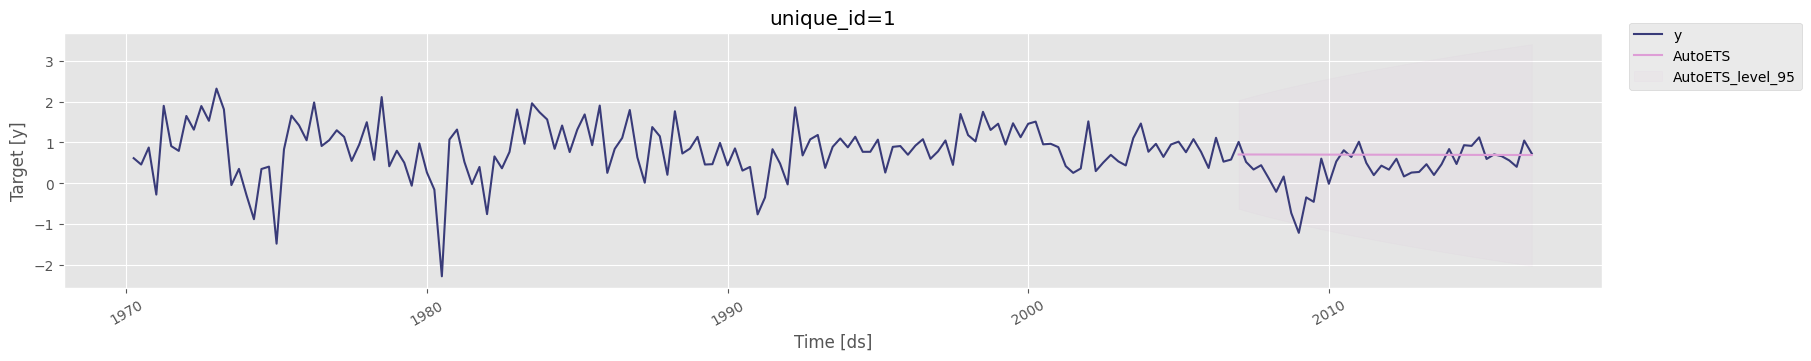

In [99]:
sf = StatsForecast(models=[AutoETS(model="AAN", season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(data, y_hat, level=[95])


In [100]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,0.403264
1,1,mape,2.656679
2,1,mase,0.588373
3,1,rmse,0.563196
4,1,smape,0.351254


In [101]:
sf.fitted_[0,0].model_

{'loglik': -306.3942466038785,
 'aic': 622.788493207757,
 'bic': np.float64(637.7406561416507),
 'aicc': 623.2140251226507,
 'mse': np.float64(0.43963810405555387),
 'amse': np.float64(0.48139130407859004),
 'fit': results(x=array([ 2.82857535e-01,  1.09283279e-04,  7.25903440e-01, -3.43095107e-04]), fn=612.788493207757, nit=96, simplex=None),
 'residuals': array([-1.09574127e-01, -2.33835718e-01,  2.49102834e-01, -9.72040942e-01,
         1.47498369e+00,  7.26940287e-02, -6.50315952e-02,  8.07709304e-01,
         2.44586684e-01,  7.53338876e-01,  1.79590619e-01,  9.16453423e-01,
         1.49652607e-01, -1.74519274e+00, -8.55421436e-01, -1.25907841e+00,
        -1.48794844e+00,  1.61641024e-01,  1.74912681e-01, -1.75945726e+00,
         1.04698879e+00,  1.57500674e+00,  8.93507410e-01,  2.76050994e-01,
         1.12385850e+00, -2.59930636e-01, -4.48048262e-02,  2.11643732e-01,
        -1.05666308e-02, -5.93834709e-01, -2.57090939e-02,  5.27953443e-01,
        -5.41695203e-01,  1.14748

Теперь возьмём какие-нибудь трендированные данные.

In [102]:
full_data = macrodata.load_pandas().data
full_data.loc[:, "ds"] = pd.date_range(start="1959.01.01", periods=len(full_data), freq="Q")
full_data = full_data.drop(columns=['year', 'quarter'])

# Да, для всех рядов одинаковый, но это просто костыль
full_data["unique_id"] = "1"

horizon = 16



/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_3596/3098955499.py:2: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



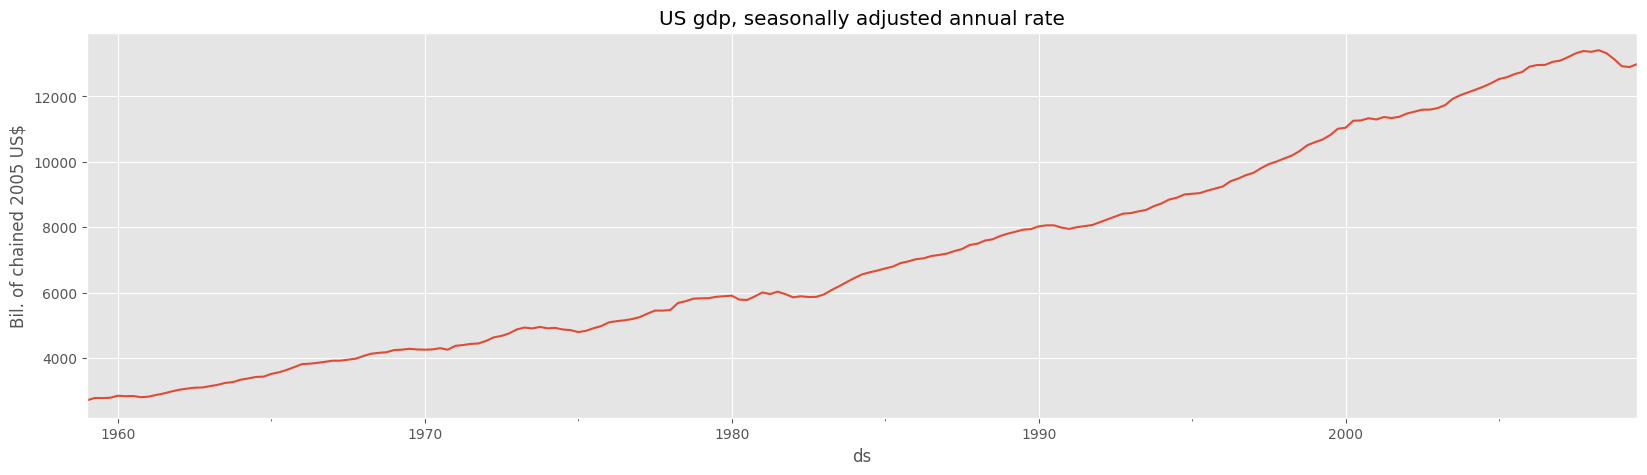

In [103]:

data = full_data[['realgdp', 'ds', 'unique_id']]
y = data.rename(columns={'realgdp': 'y'})
y.set_index('ds')['y'].plot()

plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

y_train, y_test = train_test_split(y, shuffle=False, test_size=horizon)


Text(0, 0.5, 'Bil. of chained 2005 US$')

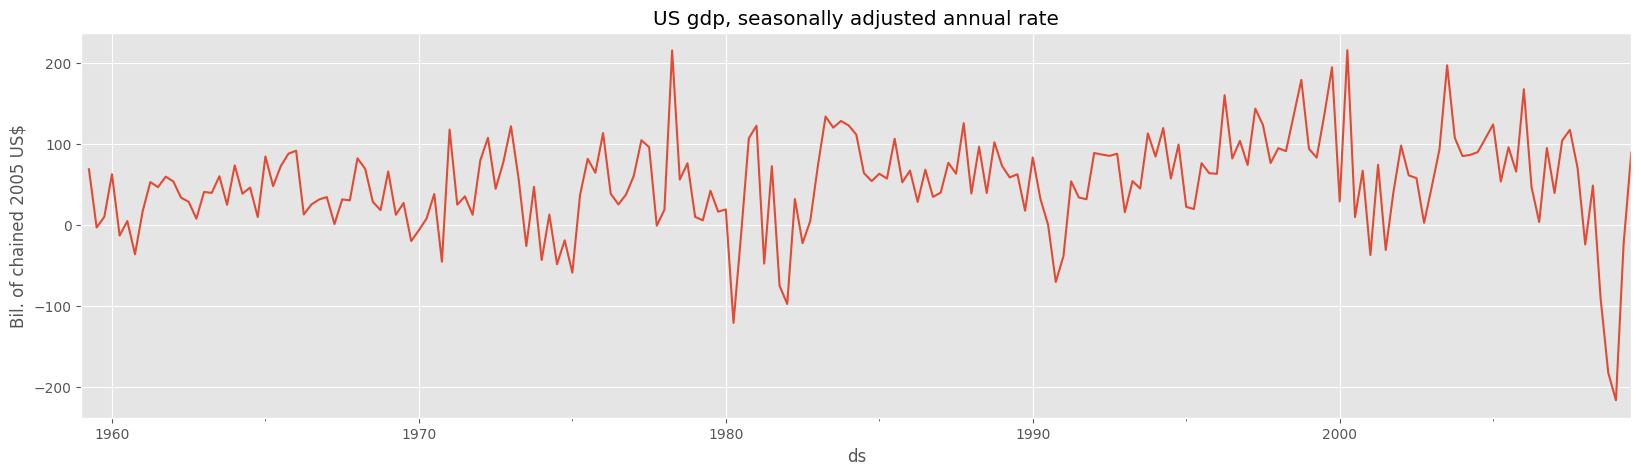

In [104]:
y.set_index('ds')['y'].diff().plot()
plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

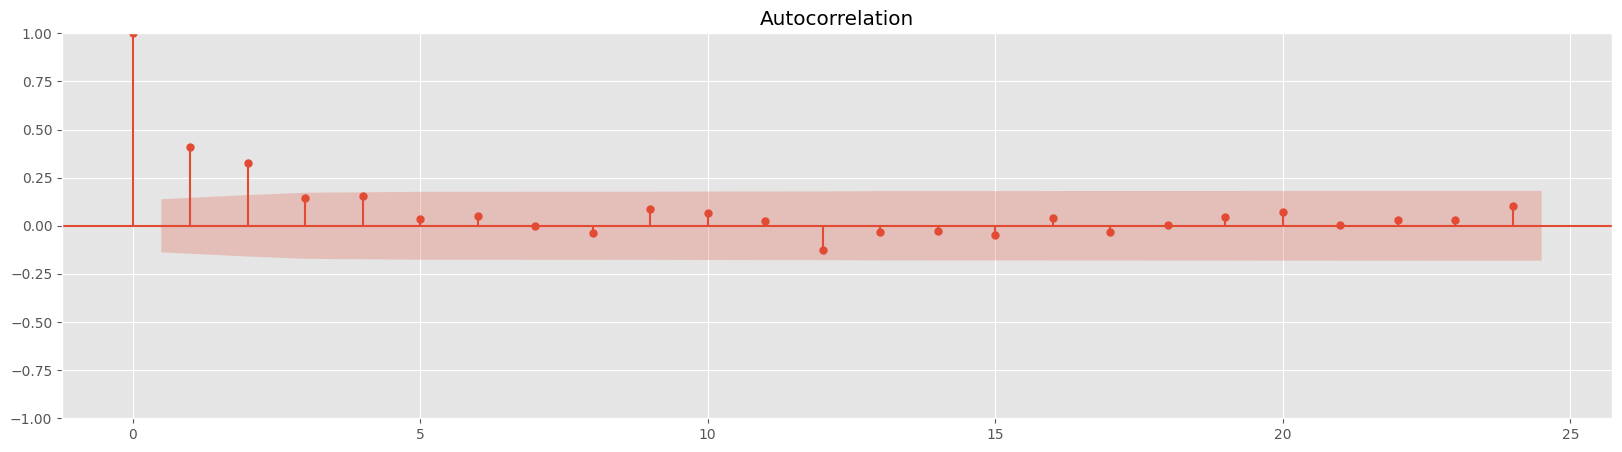

In [105]:
plot_acf(y.set_index('ds')['y'].diff().dropna());

Понятное дело, что здесь уже необходимо применять модель, в которой есть трендовая компонента. Попробуем применить.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



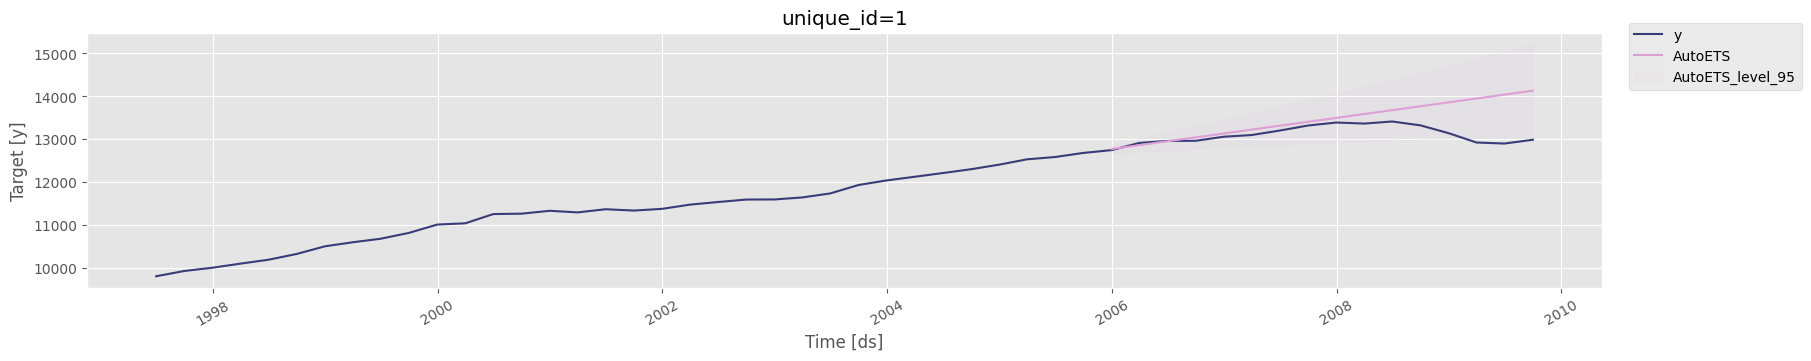

In [107]:
sf = StatsForecast(models=[AutoETS(model="AAN", season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y.tail(50), y_hat, level=[95])

In [108]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,352.076285
1,1,mape,0.026964
2,1,mase,0.274461
3,1,rmse,533.633613
4,1,smape,0.013077


Видим явную переоценку тренда. Попробуем дампировать

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



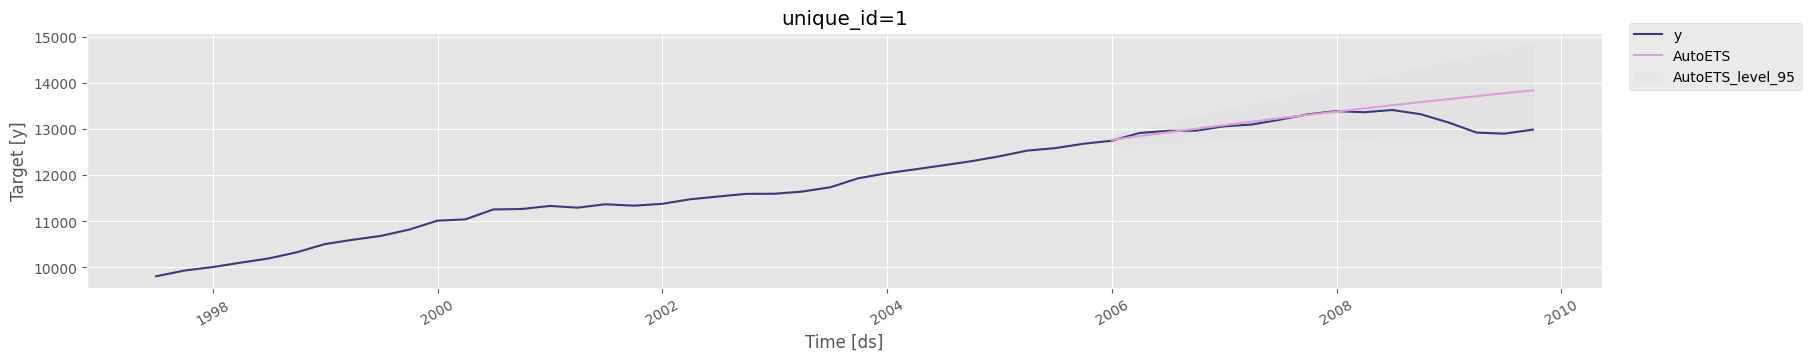

In [110]:
sf = StatsForecast(models=[AutoETS(model="AAN", damped=True, season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y.tail(50), y_hat, level=[95])

In [111]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,236.259396
1,1,mape,0.018144
2,1,mase,0.184176
3,1,rmse,393.777099
4,1,smape,0.008850


/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



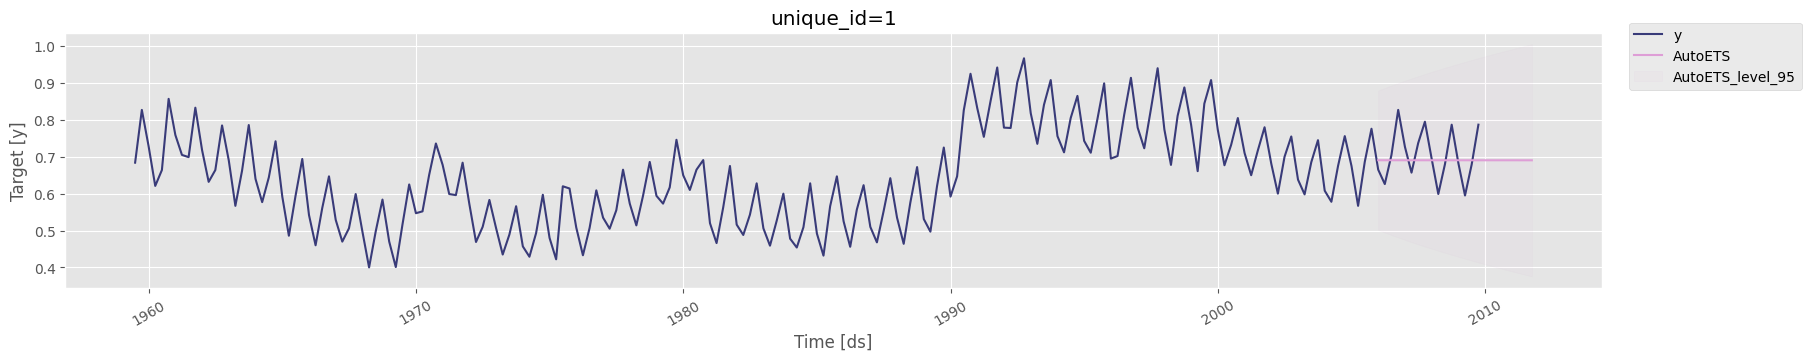

In [130]:
sf = StatsForecast(models=[AutoETS(model="MAN", damped=True, season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y, y_hat, level=[95])

In [131]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=24), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,0.054811
1,1,mape,0.077033
2,1,mase,0.499961
3,1,rmse,0.068756
4,1,smape,0.038939


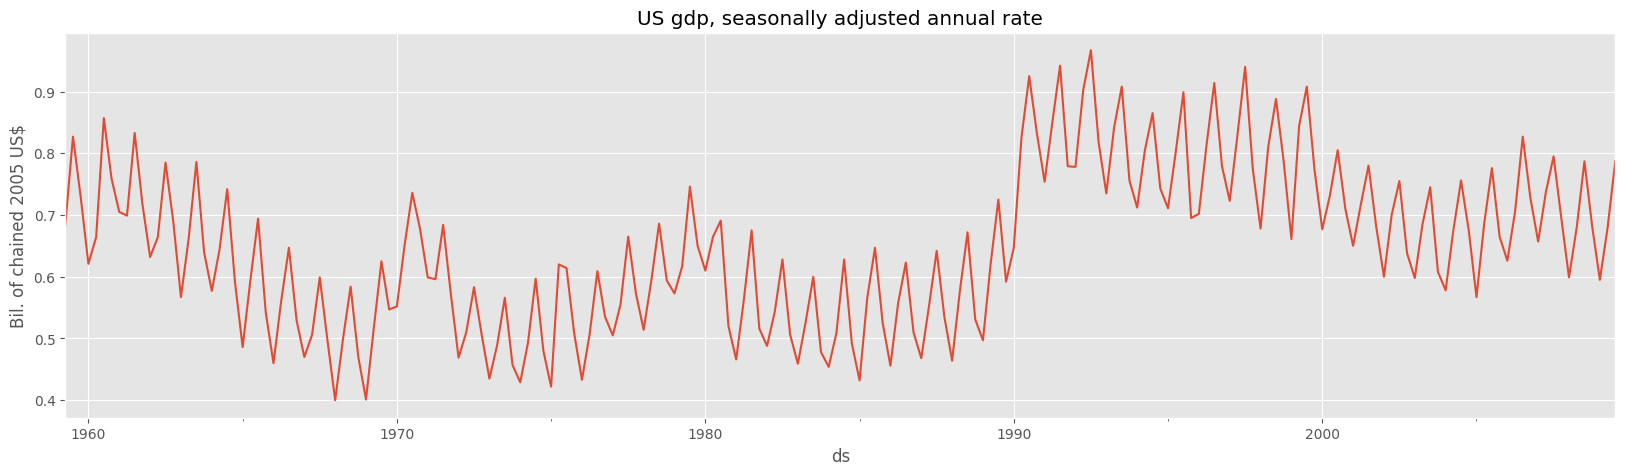

In [132]:

data = full_data[['pop', 'ds', 'unique_id']]
y = data.rename(columns={'pop': 'y'})
y['y'] = y['y'].diff()
y = y.dropna()
y.set_index('ds')['y'].plot()

plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

y_train, y_test = train_test_split(y, shuffle=False, test_size=horizon)


/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



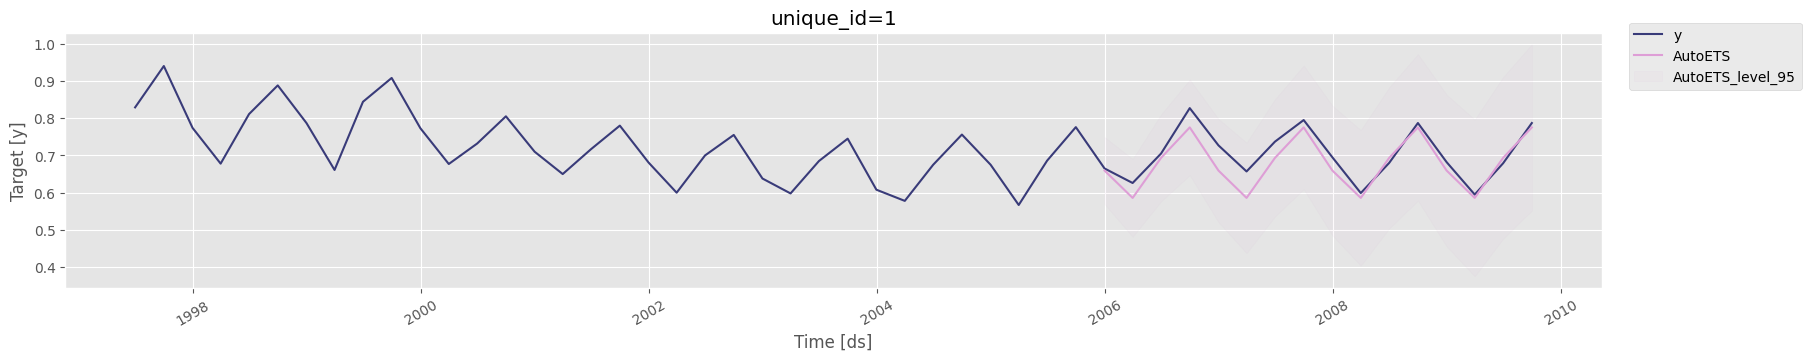

In [115]:
sf = StatsForecast(models=[AutoETS(model="AAA", damped=True, season_length=4)], freq='Q')

sf.fit(df=y_train)
y_hat = sf.predict(h=horizon, level=[95])
sf.plot(y.tail(50), y_hat, level=[95])

In [116]:
evaluate(
    y_test.merge(y_hat),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=4), ufl.rmse, ufl.smape],
    train_df=y_train,
)

,unique_id,metric,AutoETS
0,1,mae,0.027659
1,1,mape,0.039288
2,1,mase,0.657955
3,1,rmse,0.034503
4,1,smape,0.020244


In [117]:
sf.fitted_[0,0].model_


{'loglik': 145.6806576146964,
 'aic': -271.3613152293928,
 'bic': np.float64(-239.1038484922608),
 'aicc': -270.10417237224993,
 'mse': np.float64(0.0011224905492696498),
 'amse': np.float64(0.0018789455573434762),
 'fit': results(x=array([ 7.76596720e-01,  7.75501256e-04,  1.49485305e-01,  8.01721988e-01,
         7.11577805e-01,  3.28875849e-03, -7.23196565e-02,  1.05071497e-03,
         1.00275916e-01]), fn=-291.3613152293928, nit=562, simplex=None),
 'residuals': array([-0.0012075 ,  0.01133422,  0.00205612, -0.03553544, -0.00914329,
         0.0589456 ,  0.01505941,  0.02776637, -0.04736276, -0.01827912,
        -0.01219011, -0.01184914, -0.00665972, -0.0263002 ,  0.00529977,
        -0.04484973,  0.04832733, -0.00800572, -0.04628878,  0.0111925 ,
         0.01894055, -0.0321141 , -0.04990826, -0.04117146,  0.04714648,
        -0.01614838, -0.04566536, -0.01751931,  0.03222176, -0.02401685,
        -0.00900266,  0.00944761, -0.03421908, -0.02343567,  0.00489639,
        -0.0282030

In [118]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import statsmodels as sm

df = sm.datasets.macrodata.load_pandas().data
# Загрузка данных о реальном ВВП США
#Преобразуем данные из колонок в индекс. В данном случае проще всего было сгенерировать самим последовательность кварталов, чтобы не мучаться с конвертацией столбцов
df.index = pd.date_range(start = '01.01.1959', periods = len(df), freq='Q')
df = df.drop(columns = ['year', 'quarter'])
df = df.loc[:, ['realgdp']].rename(columns={'realgdp': 'y'})
df

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_3596/1002015578.py:9: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



,y
1959-03-31,2710.349
1959-06-30,2778.801
1959-09-30,2775.488
1959-12-31,2785.204
1960-03-31,2847.699
...,...
2008-09-30,13324.600
2008-12-31,13141.920
2009-03-31,12925.410
2009-06-30,12901.504


In [119]:


# Логарифмирование
df['log_y'] = np.log(df['y'])

# Визуализация с двумя осями Y
fig = go.Figure()

# Добавление исходных данных (левая ось Y)
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['y'], 
    mode='lines', 
    name='Original Data (Real GDP)',
    line=dict(color='blue')
))

# Добавление логарифмированных данных (правая ось Y)
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['log_y'], 
    mode='lines', 
    name='Log Transformed Data',
    line=dict(color='green'),
    yaxis='y2'  # Указываем вторую ось Y
))

# Настройка макета графика
fig.update_layout(
    title="Logarithmic Transformation of US Real GDP",
    xaxis_title="Year",
    yaxis=dict(
        title="Original Scale (USD Billions)", 
        # titlefont=dict(color="blue"),
        tickfont=dict(color="blue")
    ),
    yaxis2=dict(
        title="Log Scale", 
        # titlefont=dict(color="green"),
        tickfont=dict(color="green"),
        overlaying="y", 
        side="right"
    )
)

fig.show()

In [120]:
from scipy.stats import boxcox
from plotly.subplots import make_subplots

# Загрузка данных об электропотреблении
passengers = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv')
passengers['Month'] = pd.to_datetime(passengers['date'])
passengers.set_index('Month', inplace=True)
passengers = passengers.rename(columns={'value': 'y'})
passengers['ds'] = passengers.index

# Преобразование Бокса-Кокса
passengers['boxcox_y'], lambda_param = boxcox(passengers['y'])

# Визуализация
fig = make_subplots(rows=2, cols=1, subplot_titles=["Original Data", "Box-Cox Transformed Data"])
fig.add_trace(go.Scatter(x=passengers['ds'], y=passengers['y'], mode='lines', name='Original Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=passengers['ds'], y=passengers['boxcox_y'], mode='lines', name='Box-Cox Transformed Data'), row=2, col=1)
fig.update_layout(height=600, title_text="Box-Cox Transformation")
fig.show()

In [121]:
# Загрузка данных о минимальных температурах
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.rename(columns={'Temp': 'y'})
df['ds'] = df.index

# Первые разности
df['diff_y'] = df['y'].diff()

# Визуализация
fig = make_subplots(rows=2, cols=1, subplot_titles=["Original Data", "Differenced Data"])
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Original Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['ds'][1:], y=df['diff_y'][1:], mode='lines', name='Differenced Data'), row=2, col=1)
fig.update_layout(height=600, title_text="Differencing for Detrending")
fig.show()

In [122]:
from statsmodels.tsa.seasonal import STL

# STL декомпозиция
stl = STL(passengers['y'], period=12, seasonal=13)
result = stl.fit()

# Визуализация
fig = make_subplots(rows=4, cols=1, subplot_titles=["Original Data", "Trend", "Seasonal", "Residuals"])
fig.add_trace(go.Scatter(x=passengers['ds'], y=result.observed, mode='lines', name='Original Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=passengers['ds'], y=result.trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=passengers['ds'], y=result.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=passengers['ds'], y=result.resid, mode='lines', name='Residuals'), row=4, col=1)
fig.update_layout(height=1000, title_text="STL Decomposition")
fig.show()

In [124]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Загрузка данных о продажах
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv')
df['ds'] = pd.to_datetime(df['ds'])
df['unique_id'] = 'StoreSales'  # Добавляем уникальный идентификатор для совместимости с StatsForecast

# Подгонка AutoETS модели
sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS')
fitted = sf.fit(df)

df['detrended_y'] = sf.fitted_[0,0].model_['residuals']

# Визуализация
fig = make_subplots(rows=2, cols=1, subplot_titles=["Original Data", "Detrended Data"])
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Original Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['ds'], y=df['detrended_y'], mode='lines', name='Detrended Data'), row=2, col=1)
fig.update_layout(height=600, title_text="AutoETS Detrending")
fig.show()

# Кросс-валидация

In [125]:
# %%
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsforecast.utils import AirPassengersDF

# Параметры
train_size = 50
n_windows = 3
seasonal_period = 12
step_size = 12
horizon = 24

# Загрузка встроенного набора данных
df = AirPassengersDF
df['ds'] = pd.to_datetime(df['ds']) - pd.offsets.MonthBegin(1)
print(df.head())




   unique_id         ds      y
0        1.0 1948-06-01  112.0
1        1.0 1948-07-01  118.0
2        1.0 1948-08-01  132.0
3        1.0 1948-09-01  129.0
4        1.0 1948-10-01  121.0


In [126]:
# Функция для рисования графиков с поддержкой двух режимов
def plot_cross_validation(results, df, horizon, mode="custom", title="Cross-Validation with Origin and Horizon Lines"):
    fig = make_subplots(rows=3, cols=1, subplot_titles=[f"Window {i+1}" for i in range(3)])
    
    for i in range(3):
        if mode == "custom":
            # Режим для пользовательской кросс-валидации
            train = results[i]['train']
            test = results[i]['test']
            forecast = results[i]['forecast']
            origin = train['ds'].iloc[-1]  # Последняя дата тренировочного периода
        elif mode == "statsforecast":
            # Режим для StatsForecast
            cutoff = results['cutoff'].unique()[i]
            train = df[df['ds'] < cutoff]
            test = results[results['cutoff'] == cutoff]
            forecast = test.copy()  # Прогнозы уже содержатся в тестовых данных
            origin = pd.to_datetime(cutoff)  # Начало тестового периода
        else:
            raise ValueError("Unsupported mode. Use 'custom' or 'statsforecast'.")
        
        # Добавление исходных данных (только для первого окна показываем легенду)
        fig.add_trace(
            go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Data', showlegend=(i == 0), line=dict(color='blue')),
            row=i+1, col=1
        )


        # Добавление трейна (только для первого окна показываем легенду)
        fig.add_trace(
            go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Data', showlegend=(i == 0), line=dict(color='green')),
            row=i+1, col=1
        )
        
        
        # Добавление прогнозов для тестового периода
        fig.add_trace(
            go.Scatter(x=forecast['ds'], y=forecast['AutoETS'], mode='lines', line=dict(color='red', dash='dot'), 
                       name='Forecast', showlegend=(i == 0)),
            row=i+1, col=1
        )
        
        # Добавление вертикальной линии для начала тестового периода (origin)
        fig.add_vline(
            x=origin, line_width=2, line_dash="dash", line_color="green",
            row=i+1, col=1
        )
        
        # Добавление аннотации для начала тестового периода (origin)
        fig.add_annotation(
            x=origin, y=df['y'].max(),  # Позиция по оси Y — максимальное значение временного ряда
            text="Origin", showarrow=False, font=dict(color="green"), row=i+1, col=1
        )
        
        # Добавление вертикальной линии для конца горизонта прогнозирования (horizon)
        horizon_end = origin + pd.DateOffset(months=horizon)  # Корректное добавление месяцев
        fig.add_vline(
            x=horizon_end, line_width=2, line_dash="dash", line_color="purple",
            row=i+1, col=1
        )
        
        # Добавление аннотации для конца горизонта прогнозирования (horizon)
        fig.add_annotation(
            x=horizon_end, y=df['y'].max(),  # Позиция по оси Y — максимальное значение временного ряда
            text="Horizon", showarrow=False, font=dict(color="purple"), row=i+1, col=1
        )
    
    # Обновление макета графика
    fig.update_layout(height=800, title_text=title)
    fig.show()

In [127]:


# %% [markdown]
# ## 1. Нативная кросс-валидация StatsForecast

# %%
# Создание модели
model = StatsForecast(
    models=[AutoETS(season_length=12)],
    freq='M',
    n_jobs=-1
)

# Выполнение кросс-валидации
cv_results = model.cross_validation(
    df=df,
    h=horizon,
    step_size=step_size,
    n_windows=n_windows
)

# %%
# Визуализация
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

plot_cross_validation(cv_results, df, horizon, mode="statsforecast", title="StatsForecast Cross-Validation")

In [128]:
# Функция для кросс-валидации расширяющегося окна
def expanding_window_cv(df, model, horizon, step_size):
    results = []
    train_end = len(df)  # Start from the end of the dataset
    
    while train_end - horizon > 0:
        # Define the training and testing windows
        train = df.iloc[:train_end - horizon]  # Training set grows backward
        test = df.iloc[train_end - horizon:train_end]  # Testing set is fixed
        
        # Fit the model and generate forecasts
        sf = StatsForecast(models=[model], freq='MS')
        sf.fit(train)
        forecast = sf.predict(h=horizon)
        
        # Store the results
        results.append({
            'train': train,
            'test': test,
            'forecast': forecast
        })
        
        # Move the window backward
        train_end -= step_size
    
    return results

# Выполнение кросс-валидации
results = expanding_window_cv(df, AutoETS(season_length=seasonal_period), horizon, step_size)

plot_cross_validation(results, df, horizon, title="Sliding Window Cross-Validation with Origin and Horizon Lines")

In [129]:
# Функция для кросс-валидации скользящего окна
def sliding_window_cv(df, model, horizon, initial_train_size, step_size):
    results = []
    train_end = len(df)  # Start from the end of the dataset
    
    while train_end - initial_train_size - horizon >= 0:
        # Define the training and testing windows
        train = df.iloc[train_end - initial_train_size - horizon:train_end - horizon]
        test = df.iloc[train_end - horizon:train_end]
        
        # Fit the model and generate forecasts
        sf = StatsForecast(models=[model], freq='MS')
        sf.fit(train)
        forecast = sf.predict(h=horizon)
        
        # Store the results
        results.append({
            'train': train,
            'test': test,
            'forecast': forecast
        })
        
        # Move the window backward
        train_end -= step_size
    
    return results

results = sliding_window_cv(df, AutoETS(season_length=seasonal_period), horizon, train_size, step_size)

plot_cross_validation(results, df, horizon, title="Sliding Window Cross-Validation with Origin and Horizon Lines")